<a href="https://colab.research.google.com/github/tutopasini/Prediction-of-carbonate-rocks-permoporous-properties/blob/main/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação do ambiente
Rodar em ambiente com TPU, para ter acesso à 35GB de memória

In [ ]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import seaborn as sns
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

%matplotlib inline

In [ ]:
data = "/content/drive/My Drive/Estudos/Unisinos/TCC/Dataset/Fotos_K_alto/"
labels_path = "/content/drive/My Drive/Estudos/Unisinos/TCC/Dataset/SPS_69_Augusto.xlsx"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Testes

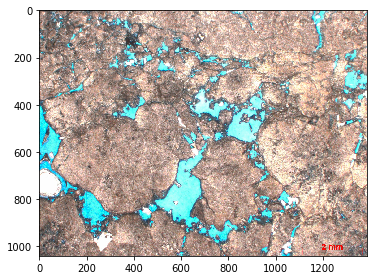

In [ ]:
img = io.imread(data + "3-SPS-69_T01_4987,05_1,25x.jpg")
io.imshow(img) 

#Funções

In [ ]:
# Carrega os dados (imagens) a partir do caminho
# Retorna as imagens carregadas e o nome delas
def load_data(path):
  entries = os.listdir(path)
  X = np.zeros((len(entries), 1036, 1384, 3), np.uint16)
  n = 0
  for entry in entries:
    img = Image.open(path + entry)
    # Algumas imagens estão em 1384x1036 e outras estão em 1388x1040
    # Aqui apenas está padronizando todas em 1384x1036
    if img.width == 1388:
      X[n,:,:] = np.array(img)[2:-2,2:-2]
    else:
      X[n,:,:] = np.array(img)
    n = n + 1
  return X, entries

In [ ]:
# Carrega os labels (porosidade e permeabilidade) da planilha, a partir de um caminho e conjunto com a identificação das imagens
def load_labels(path, labels):
  df = pd.read_excel(path, dtype={'Profundidade (m)':str})
  df.set_index('Profundidade (m)', inplace=True)
  n = 0
  y_poro = np.zeros(len(labels))
  y_perm = np.zeros(len(labels))
  y_lith = []
  for label in labels:
    y_poro[n] = df.loc[label]['Porosidade (%)'] * 0.01
    y_perm[n] = df.loc[label]['Permeabilidade (mD)'] * 0.001
    y_lith.append(df.loc[label]['Litologia (Petrobras)'])
    n = n + 1
  return y_poro, y_perm, y_lith

In [ ]:
# Segmenta as imagens do diretório
# Obs.: Foi utilizado em um experimento prévio. Não está mais sendo utilizado
def segment_images(path):
  entries = os.listdir(path)
  X = np.zeros((len(entries), 1040, 1388, 3), np.uint16)
  n = 0
  for entry in entries:
    img = cv2.imread(path + entry)
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = img.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    pixel_values.shape
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    # poro e mineral (3 pra identificar melhor. tem minerais que quase são poros e acabam sendo classificados erroneamente)
    k = 4
    _, img_labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    img_labels = img_labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[img_labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(img.shape)
    X[n,:,:] = np.array(segmented_image)
    n = n + 1
  return X, entries

# Dados

Rodar um dos dois a seguir:

In [ ]:
# Carrega as imagens originais
X, entries = load_data(data)

In [ ]:
# Imagens segmentadas com k-means clustering
#X, entries = segment_images(data)

In [ ]:
print(X.shape)
labels = []
# O nome das imagens está no formato "3-SPS-69_T01_4987,05_1,25x.jpg"
# Na planilha com porosidade e permeabilidade, cada imagem é identificada pela profundidade de onde foi coletada
# Nesse caso, sria 4987,05. Aqui está pegando essa informação do nome da imagem
labels[:] = (entry[13:20] for entry in entries)
print(labels)

(366, 1036, 1384, 3)
['5019,50', '4990,00', '5007,95', '4995,05', '4988,95', '4995,30', '4997,50', '5007,60', '5062,35', '5019,50', '4994,85', '4997,10', '5003,10', '4997,95', '4987,05', '4988,75', '5003,80', '4997,75', '4990,95', '5007,35', '5005,80', '4987,75', '4997,75', '5007,60', '4990,00', '4997,95', '4995,05', '5062,35', '4990,95', '4997,10', '4987,05', '5005,80', '4988,95', '5003,10', '5007,35', '4995,30', '5019,50', '4988,75', '4987,75', '4994,85', '5019,50', '5007,95', '4997,50', '5003,80', '5022,05', '5025,60', '4992,55', '5006,45', '5023,65', '4993,05', '5026,70', '5021,35', '4998,55', '5025,30', '5022,35', '5024,40', '5029,25', '5028,15', '5027,40', '5025,85', '4990,65', '4993,55', '5009,10', '5004,60', '5029,70', '4988,75', '5021,60', '5008,20', '5018,65', '4993,35', '5002,00', '4999,30', '4990,25', '4988,05', '4995,60', '5032,90', '5000,70', '5030,15', '5000,15', '4989,30', '5023,30', '5031,55', '5023,10', '4998,95', '4999,75', '5013,30', '4989,50', '5025,30', '4992,30',

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


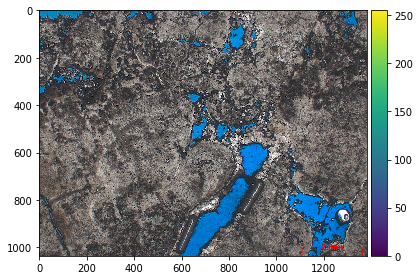

In [ ]:
io.imshow(X[0])

# Labels

In [ ]:
# Carrega os labels (porosidade e permeabilidade) a partir da identificação das imagens
y_poro, y_perm, y_litho = load_labels(labels_path, labels)
print(y_poro.shape)
print(y_perm.shape)
print(len(y_litho))

(366,)
(366,)
366


#Visualização dos dados

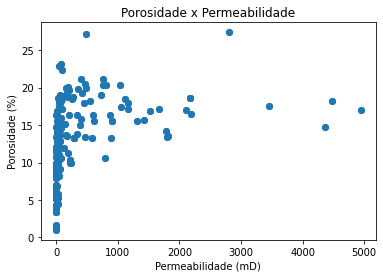

In [ ]:
# Gráfico relacionando porosidade x permeabilidade 
fig, ax = plt.subplots()
ax.scatter(y_perm * 1000, y_poro * 100)
ax.set_xlabel('Permeabilidade (mD)')
ax.set_ylabel('Porosidade (%)')
ax.set_title('Porosidade x Permeabilidade')
plt.show()

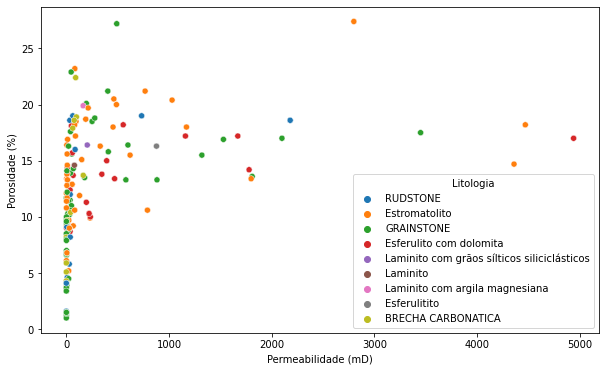

In [ ]:
# Gráfico relacionando porosidade x permeabilidade x litologia
fig, ax = plt.subplots(figsize=(10,6))
df = pd.DataFrame({'Litologia': y_litho, 'Porosidade (%)': y_poro * 100, 'Permeabilidade (mD)': y_perm * 1000})
sns.scatterplot(data=df, x="Permeabilidade (mD)", y="Porosidade (%)", hue="Litologia",ax=ax)

# Montagem dos dados para treino
A mesma rede é utilizada para predição da porosidade e da permeabilidade. Deve ser treinada com cada um dos labels separadamente



Divide as imagens (X) e os labels (y_poro para porosidade ou y_perm para permeabilidade) em conjunto de treino (70%), teste (15%) e validação (15%)

Rodar um dos dois a seguir:

In [ ]:
# Usando labels de porosidade
#X_train, X_test, y_train, y_test = train_test_split(X, y_poro, test_size=0.15, random_state=42)

In [ ]:
# Usando labels de permeabilidade
X_train, X_test, y_train, y_test = train_test_split(X, y_perm, test_size=0.15, random_state=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1875, random_state=1)
# 0.1875 * 0.8 = 0.15

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(252, 1036, 1384, 3)
(59, 1036, 1384, 3)
(55, 1036, 1384, 3)


#Processamentos adicionais
Pré processamentos para melhor treinamento da rede

In [ ]:
# Deleta os objetos não utilizados para liberar memória
del X

In [ ]:
# Converte as imagens para float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [ ]:
print(X_train.dtype)

float32


In [ ]:
# Normaliza os pixels da imagens que estavam no range RGB para um range entre 0 e 1
X_train = X_train * (1.0/255.0)
X_test = X_test * (1.0/255.0)
X_val = X_val * (1.0/255.0)

#Rede Convolucional


In [ ]:
# Early Stopping monitorando o loss sobre os dados de validação
# patience: Para após 20 epochs sem diminuição do val_loss
# restore_best_weights: Restaura os pesos da rede para o epoch com menor val_loss 
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

In [ ]:
# Modelo da CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(1036, 1384, 3)))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))
# Compile the model
model.compile(loss='huber', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1036, 1384, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 518, 692, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 518, 692, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 259, 346, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 259, 346, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 130, 173, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 130, 173, 64)      3

In [ ]:
# Treinamento. Usa os dados de treino + validação
# batch_size aumenta o tempo de treinamento, mas precisou ser reduzido para 16 para não estourar memória
# 150 epochs. Teve casos em que continou havendo melhora após 100 epochs
history = model.fit(X_train, y_train, epochs=150, callbacks=[es], validation_data=(X_val, y_val), batch_size=16)

Epoch 1/150
16/16 [==============================] - 103s 5s/step - loss: 0.4234 - mean_squared_error: 1.3997 - mean_absolute_error: 0.6622 - val_loss: 0.1157 - val_mean_squared_error: 0.2366 - val_mean_absolute_error: 0.4372
Epoch 2/150
16/16 [==============================] - 85s 5s/step - loss: 0.2318 - mean_squared_error: 0.7224 - mean_absolute_error: 0.4976 - val_loss: 0.0745 - val_mean_squared_error: 0.1585 - val_mean_absolute_error: 0.3150
Epoch 3/150
16/16 [==============================] - 87s 5s/step - loss: 0.2127 - mean_squared_error: 0.7165 - mean_absolute_error: 0.4285 - val_loss: 0.0722 - val_mean_squared_error: 0.1530 - val_mean_absolute_error: 0.3114
Epoch 4/150
16/16 [==============================] - 86s 5s/step - loss: 0.2037 - mean_squared_error: 0.6521 - mean_absolute_error: 0.4512 - val_loss: 0.0579 - val_mean_squared_error: 0.1348 - val_mean_absolute_error: 0.1743
Epoch 5/150
16/16 [==============================] - 87s 5s/step - loss: 0.1992 - mean_squared_erro

# Resultados

Text(0.5, 1.0, 'Treinamento de porosidade')

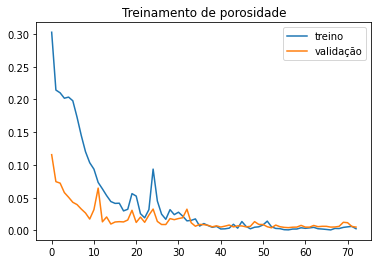

In [ ]:
# Redução do loss e val_loss no decorrer do treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['treino', 'validação'], loc='upper right')
plt.title('Treinamento de porosidade')

Text(0.5, 1.0, 'Treinamento de permeabilidade')

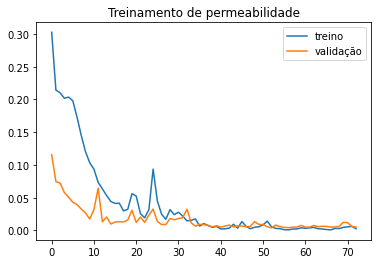

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['treino', 'validação'], loc='upper right')
plt.title('Treinamento de permeabilidade')

In [ ]:
# Usa os dados de teste para verificar a acurácia da rede
y_pred = model.predict(X_test)
y_pred

array([[ 3.50408673e-01],
       [ 2.53585856e-02],
       [ 1.38923287e-01],
       [ 3.09688300e-01],
       [ 7.38647580e-02],
       [ 2.55650431e-02],
       [ 1.60596222e-01],
       [ 1.22898825e-01],
       [ 5.15485257e-02],
       [ 4.74671650e+00],
       [-2.83145532e-03],
       [ 2.98303403e-02],
       [ 9.66381311e-01],
       [ 9.32552367e-02],
       [ 3.36235538e-02],
       [-9.86962020e-03],
       [ 4.75792587e-02],
       [ 6.81282580e-03],
       [-1.03178620e-03],
       [ 2.46155933e-01],
       [ 2.01142564e-01],
       [ 2.40263026e-02],
       [ 1.36106610e-02],
       [ 2.37965211e-02],
       [ 4.03588414e-02],
       [ 5.48647642e-02],
       [ 1.18818343e-01],
       [ 1.76245973e-01],
       [ 3.89552936e-02],
       [-5.03843278e-02],
       [ 1.60527945e-01],
       [ 5.15761518e+00],
       [ 3.51013392e-02],
       [ 1.73248723e-01],
       [ 4.88003679e-02],
       [ 1.13371897e+00],
       [ 9.26890820e-02],
       [ 1.76245943e-01],
       [ 3.4

In [ ]:
# Métricas de desempenho da rede
print('R2 Score: ' + str(r2_score(y_test, y_pred)))
print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred, squared=True)))
print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))

R2 Score: 0.9767096184524071
MAE: 0.08863438771258703
MSE: 0.02164884137123924
RMSE: 0.14713545246214196


In [ ]:
  
print('R2 Score: ' + str(r2_score(y_test, y_pred)))
print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred, squared=True)))
print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))

R2 Score: 0.9767096184524071
MAE: 0.08863438771258703
MSE: 0.02164884137123924
RMSE: 0.14713545246214196


Rodar um dos dois a seguir:

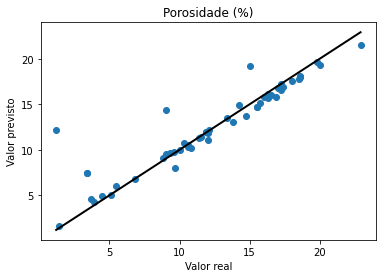

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test * 100, y_pred * 100)
ax.plot([y_test.min() * 100, y_test.max() * 100], [y_test.min() * 100, y_test.max() * 100], 'k', lw=2)
ax.set_xlabel('Valor real')
ax.set_ylabel('Valor previsto')
ax.set_title('Porosidade (%)')
plt.show()

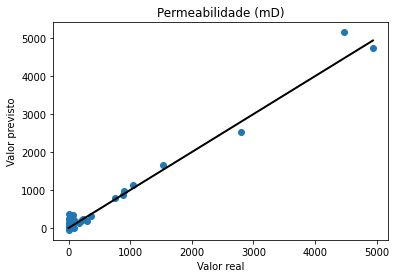

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test * 1000, y_pred * 1000)
ax.plot([y_test.min() * 1000, y_test.max() * 1000], [y_test.min() * 1000, y_test.max() * 1000], 'k', lw=2)
ax.set_xlabel('Valor real')
ax.set_ylabel('Valor previsto')
ax.set_title('Permeabilidade (mD)')
plt.show()

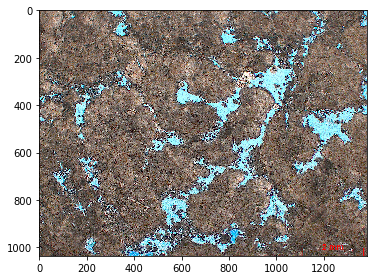

In [ ]:
# Pegar a imagem que deu maior diferença
y = [abs(y_test[x] - y_pred[x]) for x in range (len (y_test))]
idx = y.index(max(y))
io.imshow(X_test[idx])

In [ ]:
print(max(y))
y[idx] = 0

[0.6876154]


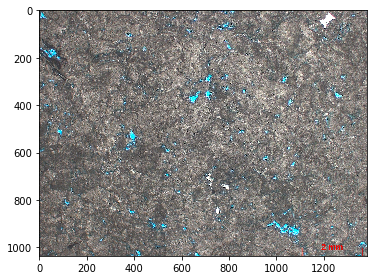

In [ ]:
idx = y.index(max(y))
io.imshow(X_test[idx])

In [ ]:
print(max(y))
y[idx] = 0

[0.36827362]


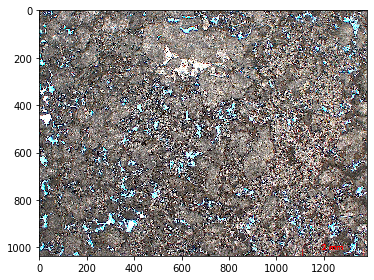

In [ ]:
idx = y.index(max(y))
io.imshow(X_test[idx])

In [ ]:
print(max(y))
y[idx] = 0

[0.3196087]
